# Exercise 04
## Lars Kühmichel, Nicolas Wolf

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAXResults
import scipy.stats as scistats

## Task 1: Granger Causality

### 1. Create a 2-variate AR(2) time series $x_t = (x_{1, t}, x_{2, t})^T$ with the given parameters.

In [141]:
T = 1000
a0 = np.array([[0.0, 0.0]])
A1 = np.array([
    [0.2, 0.0],
    [-0.2, 0.1]
])
A2 = np.array([
    [0.1, 0.0],
    [-0.1, 0.1]
])

sigma = np.array([
    [0.01, 0.0],
    [0.0, 0.01]
])

x0 = np.array([[0.0, 0.0]])

#### With `statsmodels`:

In [147]:
np.random.seed(0)

endog = x0
# this is how statsmodels parameters are ordered
params = np.concatenate((
    a0.ravel(),
    A1[0].ravel(),
    A2[0].ravel(),
    A1[1].ravel(),
    A2[1].ravel(),
    np.array([sigma[0, 0]]),
    np.array([sigma[0, 1]]),
    np.array([sigma[1, 1]]),
))

# this is a VAR(2) since we specify MA order 0
model = sm.tsa.VARMAX(endog, order=(2, 0))

initial_state = np.zeros((4, 2))
initial_state[-1] = x0
ts = model.simulate(params, nsimulations=T, initial_state=initial_state)

ts

array([[ 0.        ,  0.        ],
       [-0.01532921, -0.0171197 ],
       [-0.00260449, -0.00822987],
       ...,
       [-0.00166001, -0.00640391],
       [ 0.00226992, -0.00378512],
       [ 0.01808357, -0.00161261]])

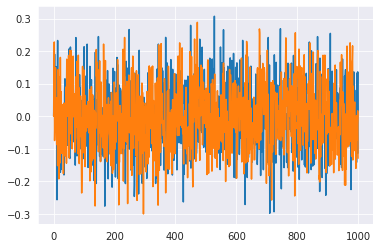

In [146]:
plt.plot(ts)

#### Manually:

In [143]:
np.random.seed(0)

def make_var(T, p, a0, A, sigma, x0):
    x = np.asarray(x0).reshape(-1, p)
    for t in range(T):
        pprime = min(len(x), p)
        Aprime = A[-pprime:]
        xprime = x[-pprime:]

        xt = a0.copy()
        product = np.einsum("BNi, Bi -> B", Aprime, xprime)
        xt += product

        noise = np.random.multivariate_normal(mean=np.zeros(p), cov=sigma)
        xt += noise

        x = np.append(x, xt, axis=0)

    return x


ts = make_var(T, 2, a0, np.array([A1, A2]), sigma, x0)
ts

array([[ 0.        ,  0.        ],
       [ 0.17640523,  0.04001572],
       [ 0.0978738 ,  0.22809089],
       ...,
       [ 0.01239203,  0.00580143],
       [ 0.13617869,  0.01642353],
       [-0.11361   , -0.12945468]])

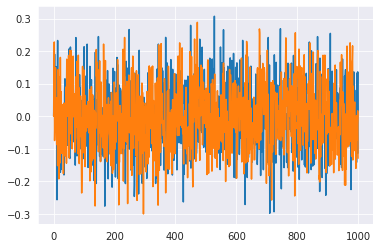

In [144]:
plt.plot(ts)

Results from `statsmodels` and manual computation differ slightly, likely because noise is sampled through different algorithms (or because statsmodels uses more than just the numpy random seed).

### 2. Given your knowledge of model parameters above, does $x_1$ Granger-cause $x_2$ or vice versa? Why?

Since $A_i(2, 1) \neq 0$ for at least one $i$, $x_1$ Granger-causes $x_2$. Similarly, since $A_i(1, 2) = 0$ for all $i$, $x_2$ does not Granger-cause $x_1$.

### 3. In a similar spirit to exercise 1 on the previous sheet, we want to find out if adding parameters to the model increases its explanatory power in a significant way.

#### Given a fixed order of the model $(p = 2)$, compute the log-likelihoods of a combined VAR(2) model where the first time series is "causing" the second time series.

In [154]:
model = sm.tsa.VARMAX(endog=ts, order=(2, 0))
result = model.fit(disp=False)

print(f"Log-Likelihood: {result.llf:.2f}")

Log-Likelihood: 6410.02


#### Compare it to the likelihood of fitting an individual AR(2) model on the second time series

To make a fair comparison, we fit a model on both time series and take the log-likelihood on both. The result is that the log-likelihood is slightly smaller, so using a VAR instead of individual ARs increased the explanatory power.

TODO: not sure if this is what they want us to do

In [156]:
m1 = sm.tsa.AutoReg(endog=ts[:, 0], lags=2)
m2 = sm.tsa.AutoReg(endog=ts[:, 1], lags=2)

r1 = m1.fit()
r2 = m2.fit()

print(f"Combined Log-Likelihood: {r1.llf + r2.llf:.2f}")

Combined Log-Likelihood: 6359.75


#### 4. Repeat this analysis by setting up a model where the second time series is causing the first one.

In [158]:
T = 1000
a0 = np.array([[0.0, 0.0]])

# now x2 causes x1
A1 = np.array([
    [0.2, -0.2],
    [0.0, 0.1]
])
A2 = np.array([
    [0.1, -0.1],
    [0.0, 0.1]
])

sigma = np.array([
    [0.01, 0.0],
    [0.0, 0.01]
])

x0 = np.array([[0.0, 0.0]])

In [159]:
np.random.seed(0)

endog = x0
# this is how statsmodels parameters are ordered
params = np.concatenate((
    a0.ravel(),
    A1[0].ravel(),
    A2[0].ravel(),
    A1[1].ravel(),
    A2[1].ravel(),
    np.array([sigma[0, 0]]),
    np.array([sigma[0, 1]]),
    np.array([sigma[1, 1]]),
))

# this is a VAR(2) since we specify MA order 0
model = sm.tsa.VARMAX(endog, order=(2, 0))

initial_state = np.zeros((4, 2))
initial_state[-1] = x0
ts = model.simulate(params, nsimulations=T, initial_state=initial_state)

ts

array([[ 0.        ,  0.        ],
       [-0.01532921, -0.0171197 ],
       [ 0.00081945, -0.01129571],
       ...,
       [-0.0011329 , -0.0082244 ],
       [ 0.00385205, -0.00546321],
       [ 0.02036779, -0.00167449]])

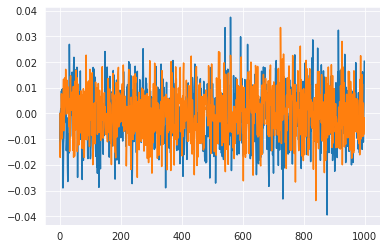

In [160]:
plt.plot(ts)

As expected, the results are effectively the same. The log-likelihood for the individual ARs is slightly higher than before.

In [161]:
model = sm.tsa.VARMAX(endog=ts, order=(2, 0))
result = model.fit(disp=False)

print(f"Log-Likelihood: {result.llf:.2f}")

Log-Likelihood: 6410.59


In [162]:
m1 = sm.tsa.AutoReg(endog=ts[:, 0], lags=2)
m2 = sm.tsa.AutoReg(endog=ts[:, 1], lags=2)

r1 = m1.fit()
r2 = m2.fit()

print(f"Combined Log-Likelihood: {r1.llf + r2.llf:.2f}")

Combined Log-Likelihood: 6380.13


#### How do the results for the individual likelihoods compare to your analysis of Granger causality?

...

### 5. How could you confirm this result in a statistically meaningful way?

The exercise already gives the answer: By computing the likelihood-ratio test statistic. This gives us a p-value.

In [164]:
from statsmodels.base.model import LikelihoodModelResults as LMR


def lr_test(restricted: LMR, unrestricted: LMR) -> float:
    """ Perform a Likelihood-Ratio-Test between a restricted and unrestricted model """
    # determine the appropriate degrees of freedom
    dof = restricted.df_resid - unrestricted.df_resid
    # likelihood-ratio-test-statistic or "D" on the sheet:
    stat_lr = -2 * (restricted.llf - unrestricted.llf)
    # perform chi-squared test (compute p-value)
    return scistats.chi2.sf(stat_lr, df=dof)

In [167]:
lr_test(restricted=r2, unrestricted=result)

0.0